In [5]:
import torch #tensors
import torch.nn as nn #weight and bias
import torch.nn.functional as F #activation functions
from torch.optim import SGD #stochastic
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

from astropy.io import fits
from astropy.table import Table as t
from astropy.cosmology import WMAP9 as cosmo
from astropy.io import misc
from astropy.coordinates import SkyCoord
import astropy.units as u
import h5py

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
import networkx as nx

In [6]:
hdu = fits.open('./data/BGS_ANY_N_clustering.dat.fits')
data_bgs = hdu[1].data

In [119]:
n_r = np.unique(data_bgs['ROSETTE_NUMBER'])
n_r

array([ 3,  6,  7, 11, 12, 13, 14, 15, 18, 19], dtype=int32)

Text(0.5, 0.92, 'Rosette n')

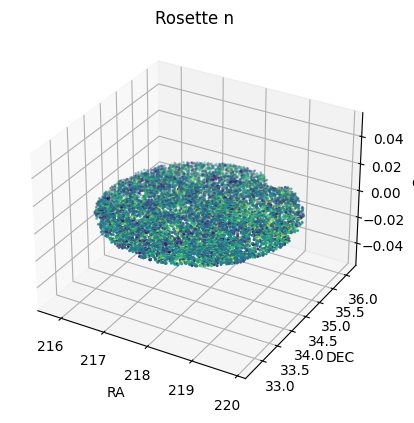

In [8]:
rosette_n = data_bgs[data_bgs['ROSETTE_NUMBER'] == 7]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

d = cosmo.comoving_distance(rosette_n['Z'])

ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_zlabel('d')

ax.scatter(rosette_n['RA'], rosette_n['DEC'], c=d, s=1, cmap='viridis')
ax.set_title('Rosette n')

Text(0.5, 1.0, 'Rosette 3')

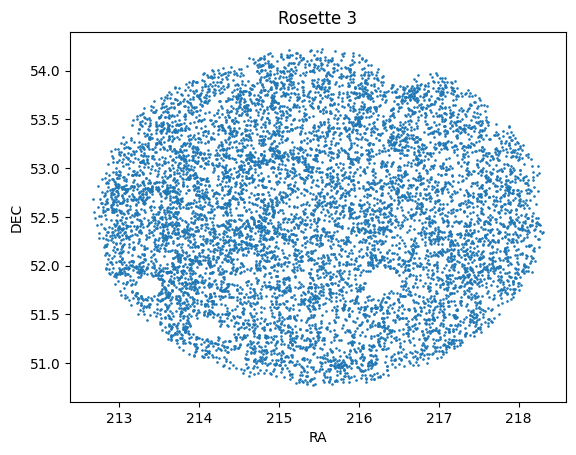

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

rosette_3 = data_bgs[data_bgs['ROSETTE_NUMBER'] == 6]
d3 = cosmo.comoving_distance(rosette_3['Z'])

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax.scatter(rosette_3['RA'], rosette_3['DEC'], s=0.8)
ax.set_title('Rosette 3')

In [10]:
rosette_n = data_bgs[data_bgs['ROSETTE_NUMBER'] == 3]
ids = rosette_n['TARGETID']

In [11]:
data_prova = misc.hdf5.read_table_hdf5('./data/BGS_ANY_full.provabgs.sv3.v0.hdf5')
data_prova

In [12]:
data_prova = h5py.File('./data/BGS_ANY_full.provabgs.sv3.v0.hdf5')
data_prova

<HDF5 file "BGS_ANY_full.provabgs.sv3.v0.hdf5" (mode r)>

In [18]:
dataset = data_prova['__astropy_table__']
selected = []

for n in range(0, 5000): #! t ~10min np.size(dataset)
    if dataset[n][0] in ids:
        selected.append((dataset[n][0], dataset[n][15]))

In [19]:
len(selected)

127

In [21]:
mass = selected
node_info = []
edge_info = []

for j in range(0, len(mass)):
    data_j = data_bgs[data_bgs['TARGETID'] == mass[j][0]]

    flux_g = data_j['FLUX_G_DERED'][0]
    flux_r = data_j['FLUX_R_DERED'][0]
    flux_z = data_j['FLUX_Z_DERED'][0]
    flux_w1 = data_j['FLUX_W1_DERED'][0]
    flux_w2 = data_j['FLUX_W2_DERED'][0]

    if mass[j][1]>0:
        node_info.append([mass[j][0], mass[j][1], flux_g, flux_r, flux_z, flux_w1, flux_w2])

        RA = data_j['RA'][0]
        DEC = data_j['DEC'][0]
        d_n = cosmo.comoving_distance(data_j['Z'])
        edge_info.append([mass[j][0], RA, DEC, d_n.value[0]])

nodes = node_info

In [22]:
len(nodes)

125

In [24]:
len(edge_info)

125

In [112]:
edges = []
edges_distances = []

for i in range(len(edge_info)):
    c1 = SkyCoord(ra=edge_info[i][1] * u.deg, dec=edge_info[i][2] * u.deg, distance=edge_info[i][3] * u.Mpc)

    for j in range(i+1,len(edge_info)): #!una sola direccion de arcos para networksx
        c2 = SkyCoord(ra=edge_info[j][1] * u.deg, dec=edge_info[j][2] * u.deg, distance=edge_info[j][3] * u.Mpc)

        ang_d = c1.separation(c2) #* esta es la distancia angular

        r = np.sqrt((edge_info[i][3]**2) + (edge_info[j][3]**2) - 2*(edge_info[i][3])*(edge_info[j][3])*np.cos(ang_d)) #! ley del coseno?

        if r < 10.0:
            edges.append((edge_info[i][0], edge_info[j][0]))
            edges_distances.append((edge_info[i][0], edge_info[j][0], r))

In [27]:
len(edges)

34

In [114]:
node_features = torch.tensor(nodes, dtype=torch.float)
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

graph = Data(x=node_features, edge_index=edge_index)
graph.num_nodes = len(nodes)
graph.num_edges = len(edges)

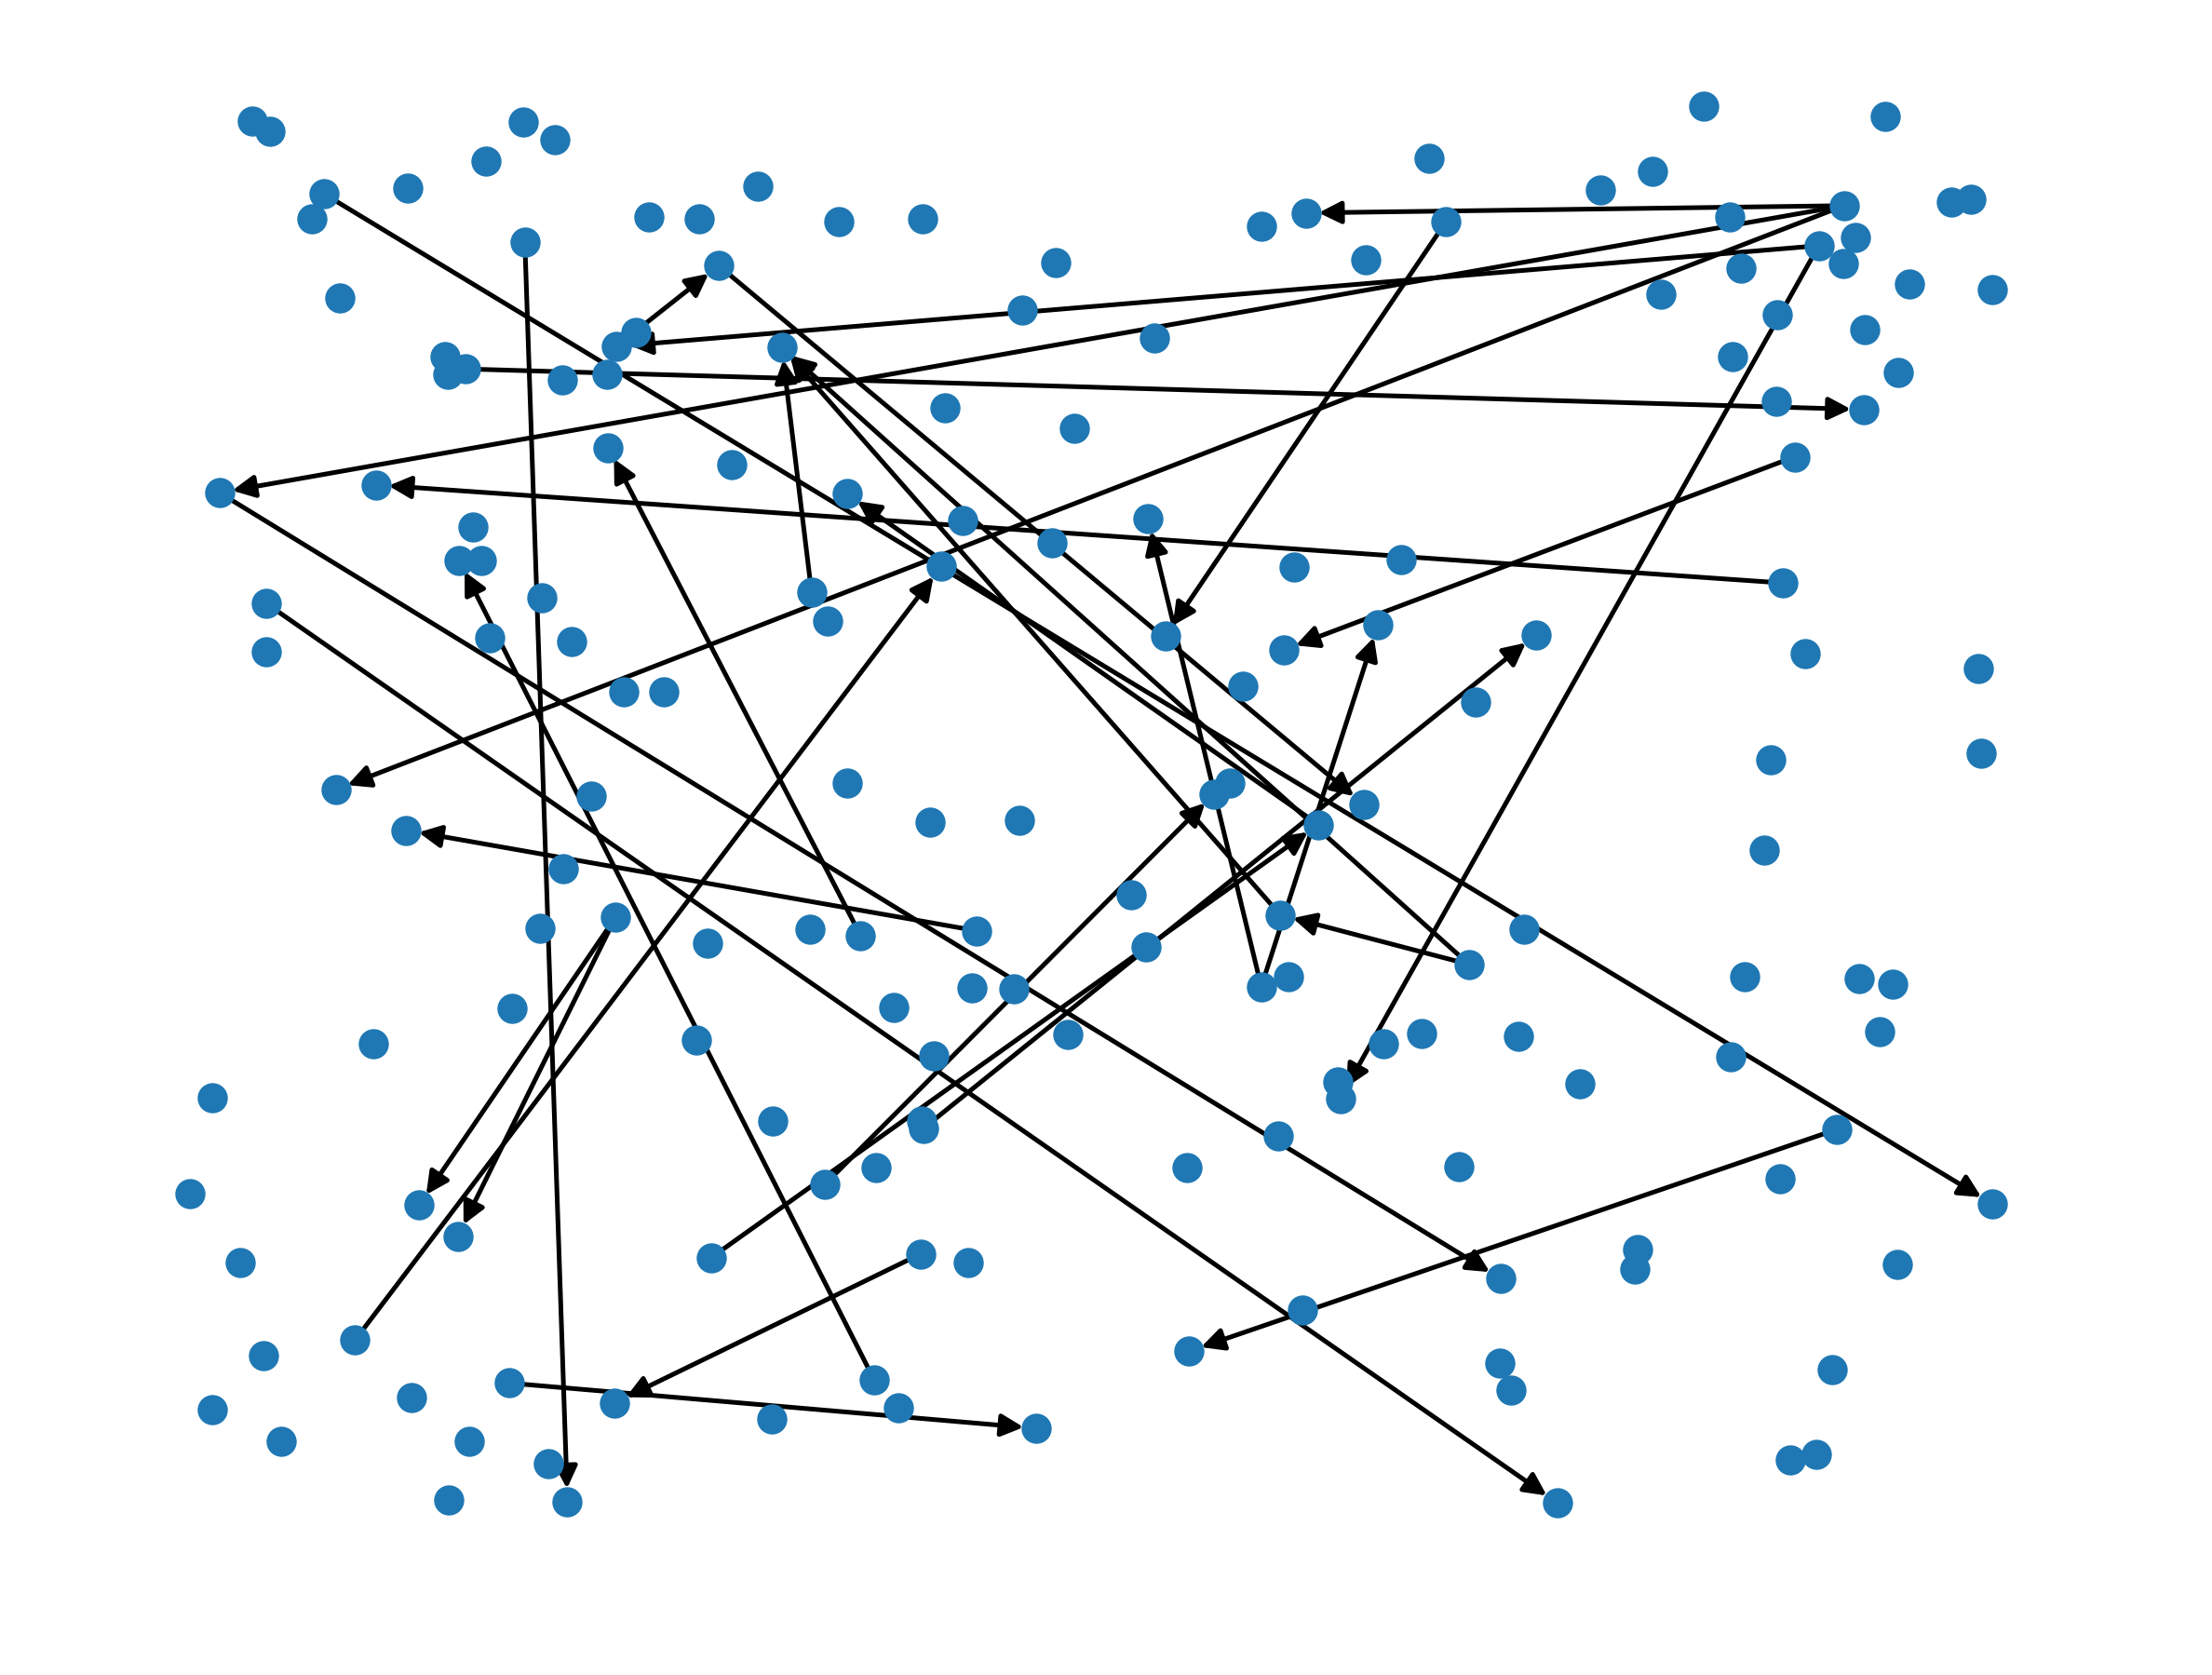

In [115]:
networkx_graph = to_networkx(graph)
nx.draw_random(networkx_graph, node_size=30, with_labels=False)

<Figure size 2304x1728 with 0 Axes>

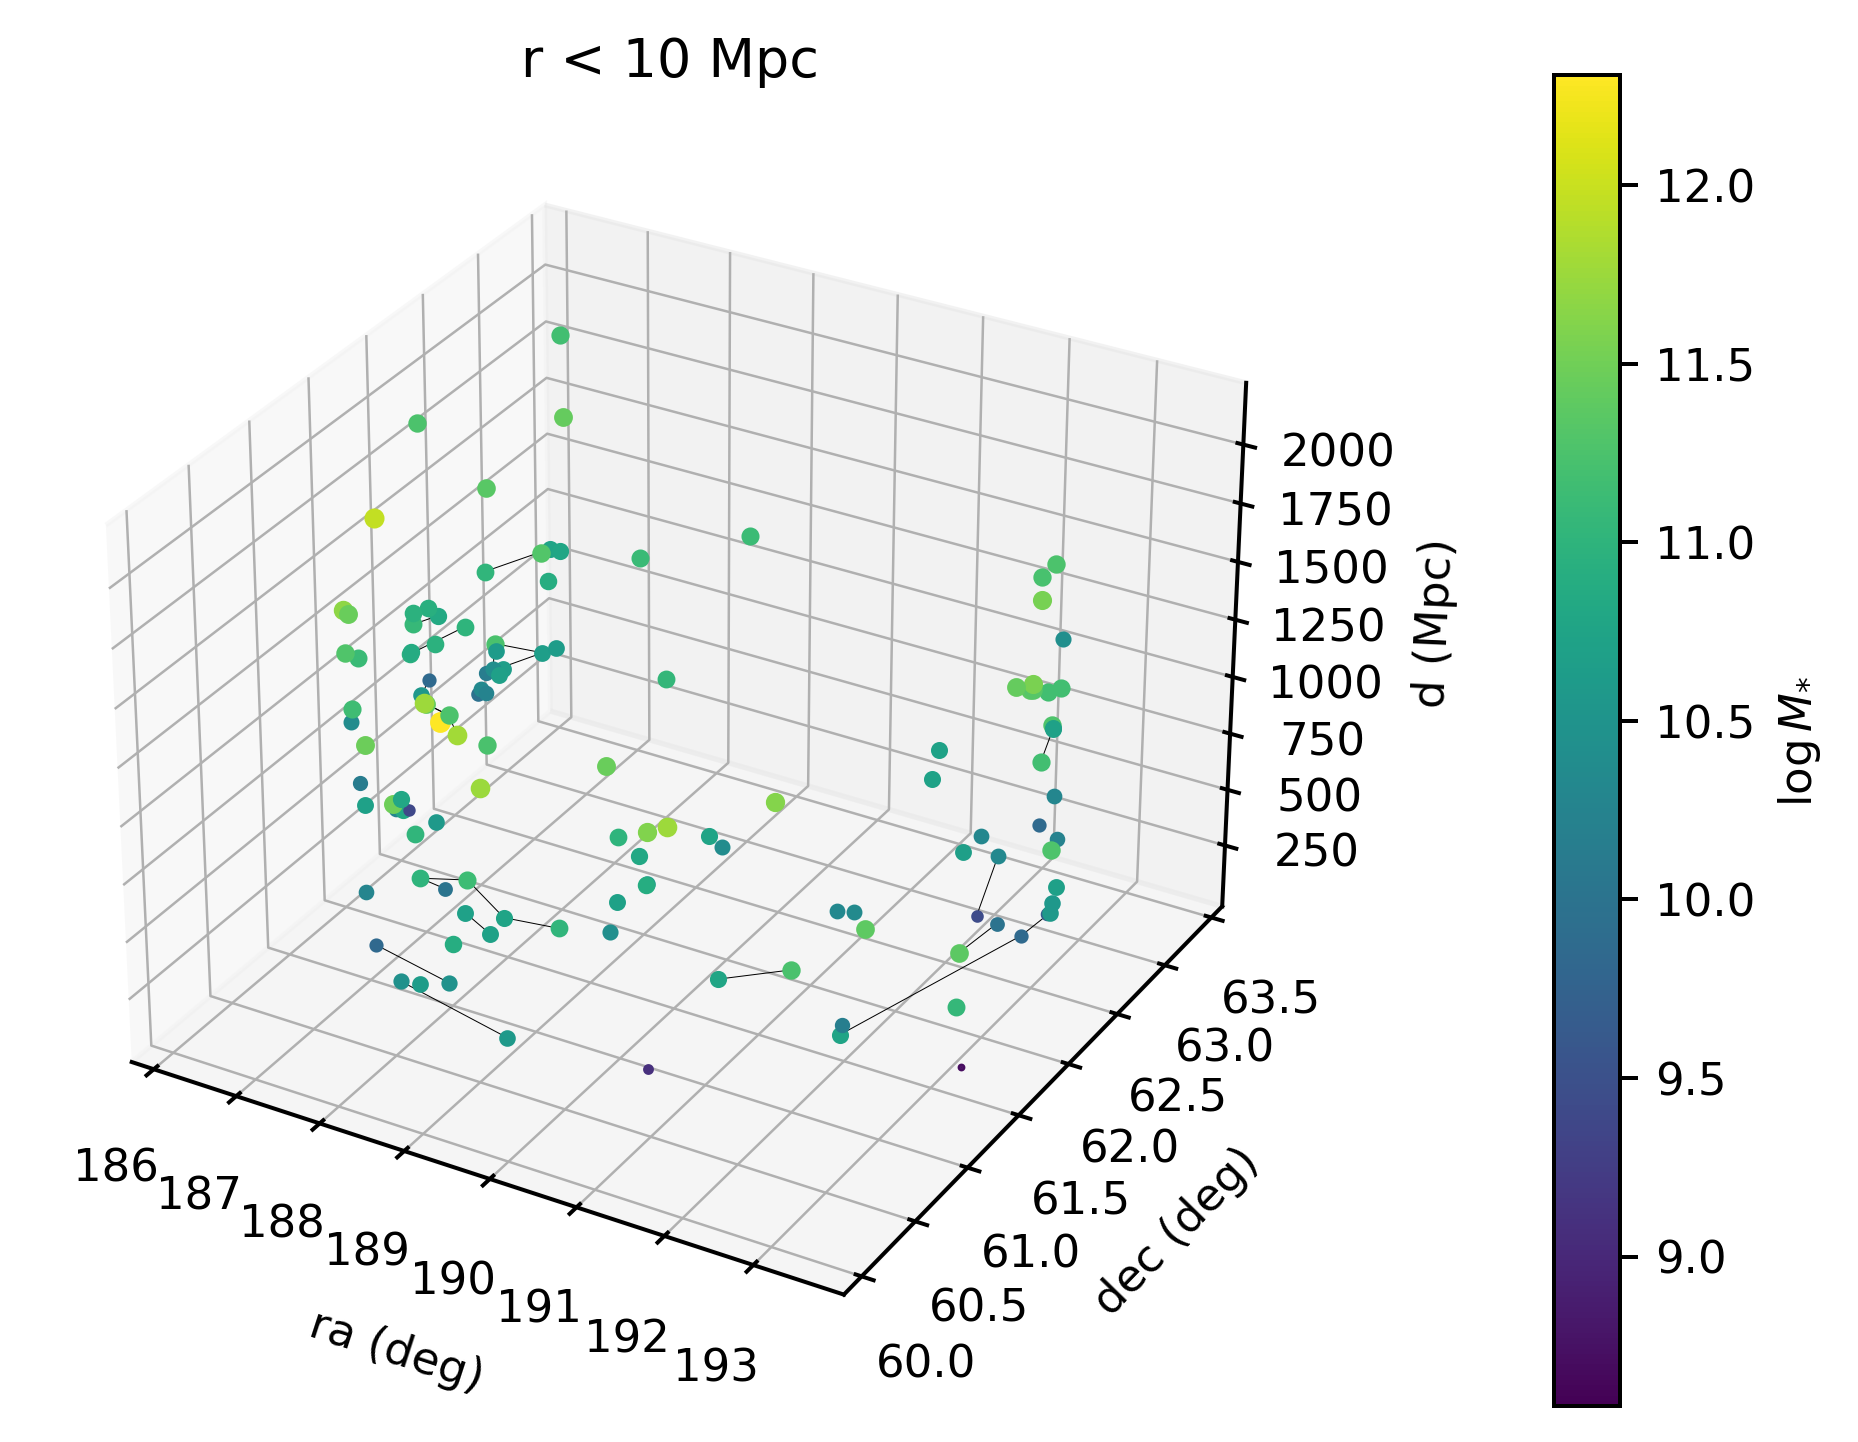

In [116]:
plt.rcParams["font.size"] = 9
plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=1.05, bottom=0.1)
plt.rcParams['figure.dpi'] = 360

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = cm.viridis
plt.set_cmap(cmap)

c_values = []
for i in range(len(edge_info)):
    c_values.append(node_info[i][1])
norm = (c_values-np.min(c_values))/(np.max(c_values)-np.min(c_values))

min_norm = np.min(c_values)
max_norm = np.max(c_values)

sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_norm, vmax=max_norm))
sm.set_array([])

for i, node in enumerate(edge_info):
    x, y, z = node[1], node[2], node[3]
    ax.scatter(x, y, z, c=[cmap(norm[i])], s=norm[i]*10)

for edge in edges_distances:
    for n in edge_info:
        if (n[0]==edge[0]):
            x1 = n[1]
            y1 = n[2]
            z1 = n[3]
        elif (n[0]==edge[1]):
            x2 = n[1]
            y2 = n[2]
            z2 = n[3]

    x = [x1, x2]
    y = [y1, y2]
    z = [z1, z2]
    ax.plot(x, y, z, color='black', linewidth=0.2)

ax.set_xlabel('ra (deg)')
ax.set_ylabel('dec (deg)')
ax.set_zlabel('d (Mpc)')
plt.title(f'r < {10} Mpc')

ax.xaxis._axinfo["grid"]['linewidth'] = 0.5
ax.yaxis._axinfo["grid"]['linewidth'] = 0.5
ax.zaxis._axinfo["grid"]['linewidth'] = 0.5

cbar = plt.colorbar(sm, ax=ax, pad=0.14)
cbar.set_label(r'$\log M_{*}$')

In [109]:
def graph():

    plt.rcParams["font.size"] = 6
    plt.rcParams['figure.dpi'] = 360
    plt.tight_layout()
    plt.subplots_adjust(wspace=2,hspace=100)

    dist = [10.0,50.0,100.0,1000.0]
    pos = [(0,0),(0,1),(1,0),(1,1)]

    fig, axis = plt.subplots(2, 2,subplot_kw=dict(projection='3d'))
    plt.suptitle('Galaxy distances')

    for p, d in enumerate(dist):
        edges = []
        edges_distances = []

        for i in range(len(edge_info)):
            c1 = SkyCoord(ra=edge_info[i][1] * u.deg, dec=edge_info[i][2] * u.deg, distance=edge_info[i][3] * u.Mpc)

            for j in range(i+1,len(edge_info)): #!una sola direccion de arcos para networksx
                c2 = SkyCoord(ra=edge_info[j][1] * u.deg, dec=edge_info[j][2] * u.deg, distance=edge_info[j][3] * u.Mpc)

                ang_d = c1.separation(c2) #* esta es la distancia angular

                r = np.sqrt((edge_info[i][3]**2) + (edge_info[j][3]**2) - 2*(edge_info[i][3])*(edge_info[j][3])*np.cos(ang_d)) #! ley del coseno?

                if r < d:
                    edges.append((edge_info[i][0], edge_info[j][0]))
                    edges_distances.append((edge_info[i][0], edge_info[j][0], r))

        cmap = cm.viridis
        plt.set_cmap(cmap)

        c_values = []
        for i in range(len(edge_info)):
            c_values.append(node_info[i][1])
        norm = (c_values-np.min(c_values))/(np.max(c_values)-np.min(c_values))

        min_norm = np.min(c_values)
        max_norm = np.max(c_values)

        sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_norm, vmax=max_norm))
        sm.set_array([])

        for j, node in enumerate(edge_info):
            x, y, z = node[1], node[2], node[3]
            axis[pos[p][0], pos[p][1]].scatter(x, y, z, c=[cmap(norm[j])], s=norm[j]*10)

        for edge in edges_distances:
            for n in edge_info:
                if (n[0]==edge[0]):
                    x1 = n[1]
                    y1 = n[2]
                    z1 = n[3]
                elif (n[0]==edge[1]):
                    x2 = n[1]
                    y2 = n[2]
                    z2 = n[3]

            x = [x1, x2]
            y = [y1, y2]
            z = [z1, z2]
            axis[pos[p][0], pos[p][1]].plot(x, y, z, color='black', linewidth=(5/d))

        axis[pos[p][0], pos[p][1]].set_title(f'r < {d} Mpc')

        cbar = fig.colorbar(sm, ax=ax, pad=0.14)
        cbar.set_label(r'$\log M_{*}$')

        axis[pos[p][0], pos[p][1]].set_xlabel('ra (deg)')
        axis[pos[p][0], pos[p][1]].set_ylabel('dec (deg)')
        axis[pos[p][0], pos[p][1]].set_zlabel('d (Mpc)')

<Figure size 2304x1728 with 0 Axes>

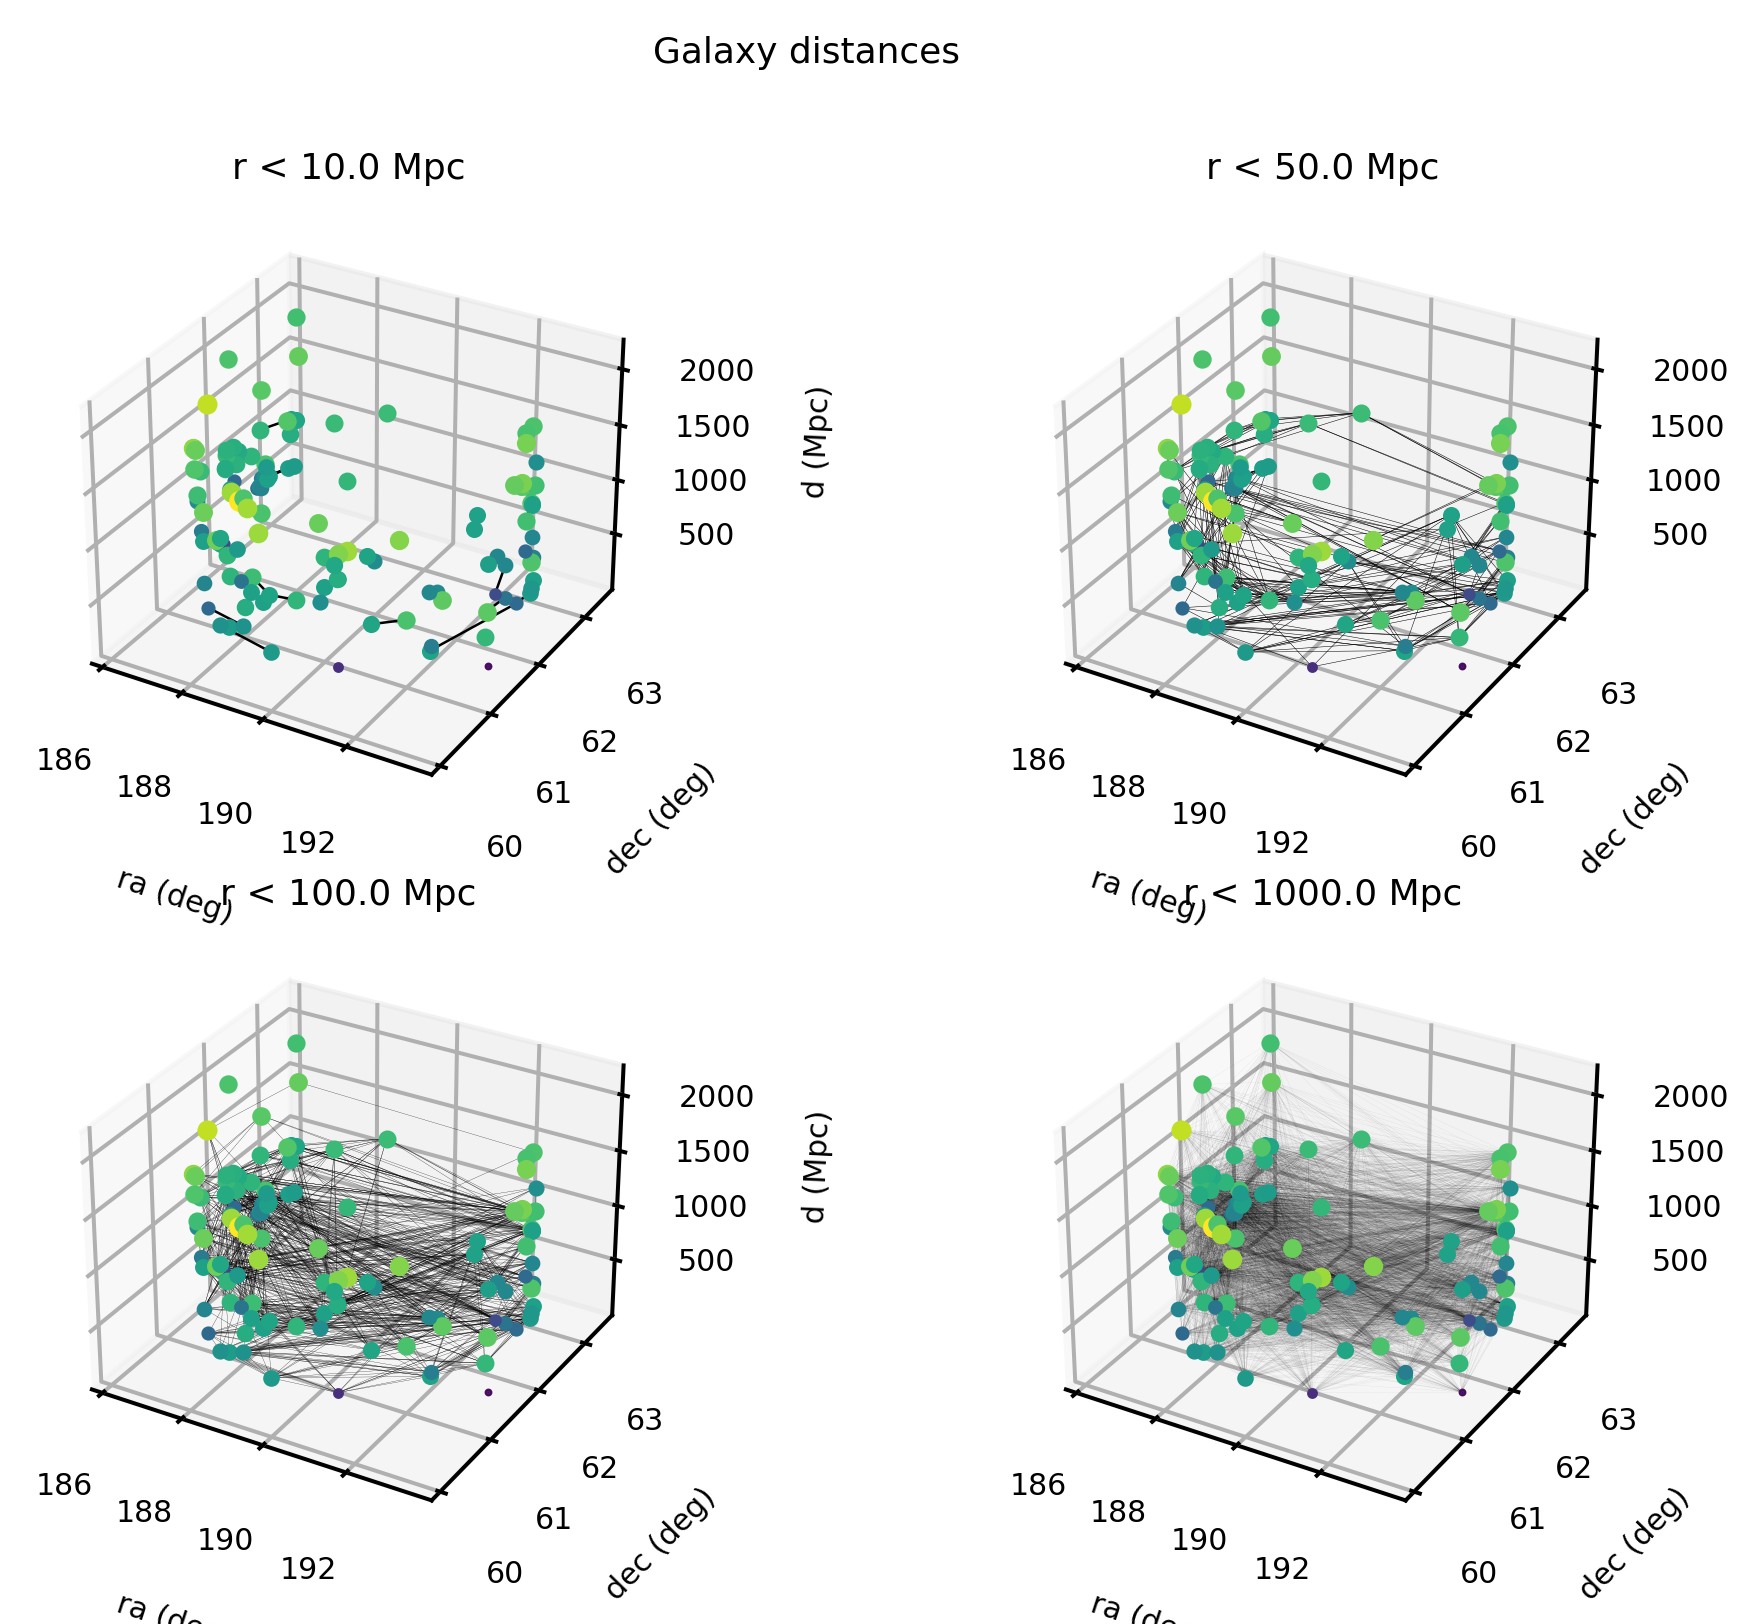

In [110]:
graph()

## Código optmizado

In [ ]:
hdu = fits.open('./data/BGS_ANY_N_clustering.dat.fits')
data_prova = h5py.File('./data/BGS_ANY_full.provabgs.sv3.v0.hdf5')

In [ ]:
data_bgs = hdu[1].data
n_r = np.unique(data_bgs['ROSETTE_NUMBER'])
rosette_n = data_bgs[data_bgs['ROSETTE_NUMBER'] == 3]
ids = rosette_n['TARGETID']

In [ ]:
dataset = data_prova['__astropy_table__']
selected = []

for n in range(np.size(dataset)): #! t ~10min np.size(dataset)
    if dataset[n][0] in ids:
        selected.append((dataset[n][0], dataset[n][15]))

In [ ]:
dataset = data_prova['__astropy_table__']
selected = [(row[0], row[15]) for row in dataset if row[0] in ids]

In [ ]:
edges = []
edges_distances = []

edge_info = np.array(edge_info)
coords = SkyCoord(ra=edge_info[:, 1] * u.deg, dec=edge_info[:, 2] * u.deg, distance=edge_info[:, 3] * u.Mpc)

for i in range(len(edge_info)):
    c1 = coords[i]

    separations = c1.separation(coords[i+1:])
    distances = np.sqrt((edge_info[i, 3]**2) + (edge_info[i+1:, 3]**2) - 2*(edge_info[i, 3])*(edge_info[i+1:, 3])*np.cos(separations))

    valid_indices = np.where(distances < 10.0)[0]

    if len(valid_indices) > 0:
        valid_indices += i + 1  # Ajusta los índices para obtener el índice correcto en edge_info
        edges.extend([(edge_info[i, 0], edge_info[j, 0]) for j in valid_indices])
        edges_distances.extend([(edge_info[i, 0], edge_info[j, 0], distances[k]) for k, j in enumerate(valid_indices)])

In [ ]:
node_features = torch.tensor(nodes, dtype=torch.float)
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

graph = Data(x=node_features, edge_index=edge_index)
graph.num_nodes = len(nodes)
graph.num_edges = len(edges)

In [ ]:
networkx_graph = to_networkx(graph)
nx.draw_random(networkx_graph, arrows=False, width=0.1, node_size=30, with_labels=False)

In [ ]:
plt.rcParams["font.size"] = 9
plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=1.05, bottom=0.1)
plt.rcParams['figure.dpi'] = 360

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = cm.viridis
plt.set_cmap(cmap)

c_values = []
for i in range(len(edge_info)):
    c_values.append(node_info[i][1])
norm = (c_values-np.min(c_values))/(np.max(c_values)-np.min(c_values))

min_norm = np.min(c_values)
max_norm = np.max(c_values)

sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_norm, vmax=max_norm))
sm.set_array([])

for i, node in enumerate(edge_info):
    x, y, z = node[1], node[2], node[3]
    ax.scatter(x, y, z, c=[cmap(norm[i])], s=norm[i]*10)

for edge in edges_distances:
    for n in edge_info:
        if (n[0]==edge[0]):
            x1 = n[1]
            y1 = n[2]
            z1 = n[3]
        elif (n[0]==edge[1]):
            x2 = n[1]
            y2 = n[2]
            z2 = n[3]

    x = [x1, x2]
    y = [y1, y2]
    z = [z1, z2]
    ax.plot(x, y, z, color='black', linewidth=0.2)

ax.set_xlabel('ra (deg)')
ax.set_ylabel('dec (deg)')
ax.set_zlabel('d (Mpc)')
plt.title(f'r < {10} Mpc')

ax.xaxis._axinfo["grid"]['linewidth'] = 0.5
ax.yaxis._axinfo["grid"]['linewidth'] = 0.5
ax.zaxis._axinfo["grid"]['linewidth'] = 0.5

cbar = plt.colorbar(sm, ax=ax, pad=0.14)
cbar.set_label(r'$\log M_{*}$')